# Load Datasets

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

+ X_label IMG

In [2]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [3]:
d_path = 'D:\AlbumCover/'
img_dataset = pd.read_csv('./dataset/img.csv')


In [4]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)

In [5]:
# check np array is well defined
img_arr.shape

(1231, 150, 150, 3)

+ X_label Facial

In [6]:
pre_facial = pd.read_csv('./dataset/facial.csv')

if 'Unnamed: 0' in pre_facial.columns:
    pre_facial = pre_facial.drop('Unnamed: 0', axis=1)

In [7]:
imsi = pre_facial.copy()

In [8]:
# categorical data to one-hot
fac_input_df = pd.get_dummies(imsi, prefix=['gender', 'dominant_race'])

# Normalization
fac_input_norm = (fac_input_df - fac_input_df.mean()) / fac_input_df.std()

fac_input = np.array(fac_input_norm)

In [9]:
# check np array is well defined
fac_input.shape

(1231, 16)

+ X_label Color

In [10]:
clr_data = pd.read_csv('./dataset/clr.csv')
if 'Unnamed: 0' in clr_data.columns:
    clr_data = clr_data.drop('Unnamed: 0', axis=1)

In [11]:
clr_input = np.array( (clr_data - clr_data.mean())/clr_data.std() )

In [12]:
# check np array is well defined
clr_input.shape

(1231, 3)

+ y_label

In [13]:
y_data = pd.read_csv('./dataset/y_label.csv')

y_out = np.array(y_data)

img_arr = img_arr.astype('float64')

---

# Modeling w/ BP-MLL

Make Model using keras functional api

In [37]:
from keras.layers import Input
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

def multi_input_model(input_shape, classes):
    # IMG Conv Model (not in use)
    # real_conv_input = tf.keras.Input(shape=(150,150,3,))
    # conv_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape, input_shape))
    # conv_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(real_conv_input)
    # conv_laye2 = keras.layers.Dropout(0.2)(conv_layer)
    # conv_laye3 = keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(conv_laye2)
    # conv_laye4 = keras.layers.MaxPooling2D(pool_size=(4,4))(conv_laye3)
    # conv_laye5 = keras.layers.Dropout(0.2)(conv_laye4)
    # conv_laye6 = keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(conv_laye5)
    # conv_laye7 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_laye6)
    # conv_laye8 = keras.layers.Dropout(0.2)(conv_laye7)
    # conv_laye9 = keras.layers.Flatten()(conv_laye8)
    # conv_lay10 = keras.layers.Dense(64, activation='relu')(conv_laye9)
    # conv_output = keras.layers.Dense(classes, activation='softmax')(conv_lay10)
    
    # IMG ResNet Model
    # resnet_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape, input_shape))
    resnet_input = tf.keras.Input(shape=(input_shape,input_shape,3))
    #resnet_resc = tf.keras.preprocessing.Rescaling(1.0/255)(resnet_input)
    resnet_output = tf.keras.applications.ResNet50(weights=None, input_shape=(input_shape,input_shape,3), classes=classes)(resnet_input)
    
    # face MLP Model
    real_face_input = tf.keras.layers.Input(shape=(16,))
    face_input = tf.keras.layers.Dense(256, activation='relu')(real_face_input)
    # face_layer = keras.layers.Dropout(0.2)(face_input)
    face_laye2 = tf.keras.layers.Dense(128, activation='relu')(face_input)#(face_layer)
    # face_laye3 = keras.layers.Dropout(0.2)(face_laye2)
    face_laye4 = tf.keras.layers.Dense(64, activation='relu')(face_laye2)#(face_laye3)
    # face_laye5 = keras.layers.Dropout(0.2)(face_laye4)
    face_output = tf.keras.layers.Dense(classes, activation='sigmoid')(face_laye4)#(face_laye5)
    
    # # face MLP Model /w relu
    # real_face_input = tf.keras.layers.Input(shape=(16,))
    # face_input = tf.keras.layers.Dense(256, activation='relu')(real_face_input)
    # #face_layer = keras.layers.Dropout(0.2)(face_input)
    # face_laye2 = tf.keras.layers.Dense(128, activation='relu')(face_input)#(face_layer)
    # #face_laye3 = keras.layers.Dropout(0.2)(face_laye2)
    # face_laye4 = tf.keras.layers.Dense(64, activation='relu')(face_laye2)#(face_laye3)
    # #face_laye5 = keras.layers.Dropout(0.2)(face_laye4)
    # face_output = tf.keras.layers.Dense(classes, activation='softmax')(face_laye4)#(face_laye5)
    
    
    
    # clr MLP Model
    real_clr_input = tf.keras.layers.Input(shape=(3,))
    clr_input = tf.keras.layers.Dense(64, activation='relu')(real_clr_input)
    clr_layer = tf.keras.layers.Dense(32, activation='relu')(clr_input)
    clr_output = tf.keras.layers.Dense(classes, activation='sigmoid')(clr_layer)
    
    
    # concatenate
    concat = tf.keras.layers.Concatenate(axis=-1)([resnet_output, face_output, clr_output])
    
    # final model
    final_input = tf.keras.layers.Dense(128, activation='relu')(concat)
    final_layer = tf.keras.layers.Dropout(0.2)(final_input)
    final_laye2 = tf.keras.layers.Dense(128, activation='relu')(final_layer)
    final_laye3 = tf.keras.layers.Dropout(0.2)(final_laye2)
    fianl_laye4 = tf.keras.layers.Dense(64, activation='relu')(final_laye3)
    final_output = tf.keras.layers.Dense(classes, activation='sigmoid')(fianl_laye4)
    
    
    model = tf.keras.models.Model([resnet_input, real_face_input, real_clr_input], final_output)
    
    return model





In [25]:
NUM_CLASSES = 15
IMG_SIZE = 150

In [38]:
model = multi_input_model(IMG_SIZE, NUM_CLASSES)

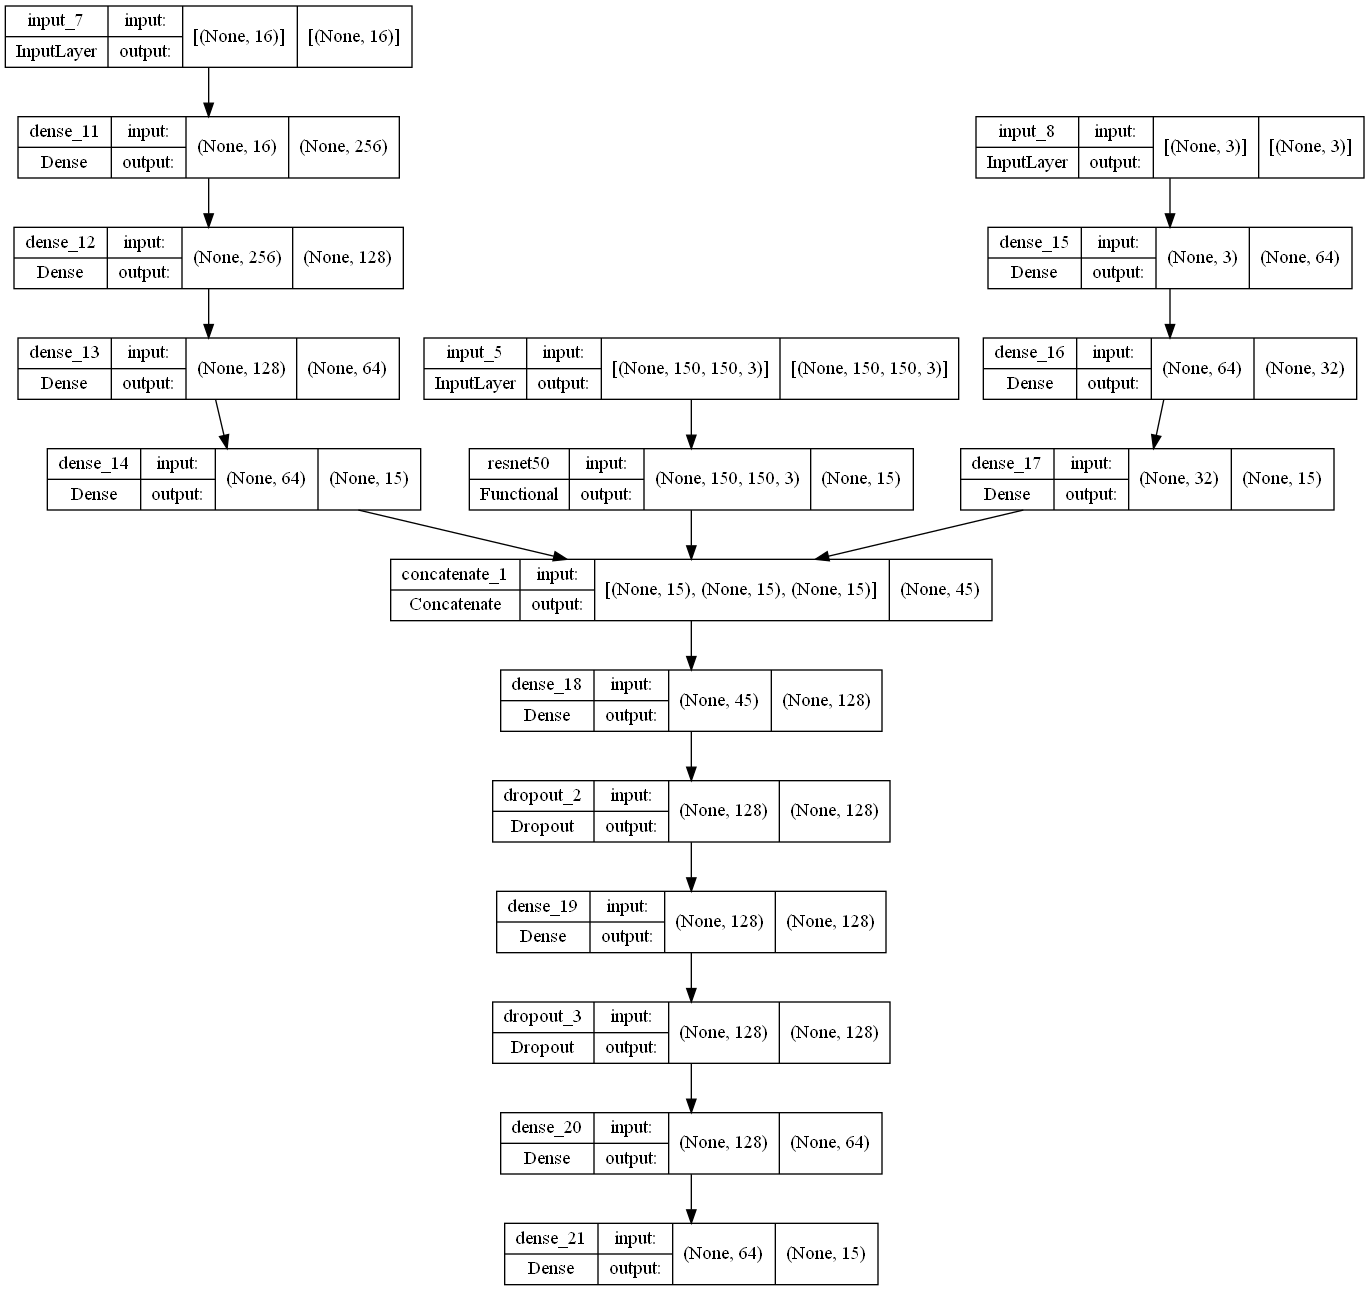

In [27]:
# you can see model summary

tf.keras.utils.plot_model(model, show_shapes=True)

Compiling the Model

In [28]:
def emr(y_true, y_pred):
    n = len(y_true)
    row_indicators = np.all(y_true == y_pred, axis = 1) # axis = 1 will check for equality along rows.\n",
    exact_match_count = np.sum(row_indicators)
    return exact_match_count/n

In [29]:
from keras import backend as K
import tensorflow as tf
 
# Compatible with tensorflow backend
 
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
                        - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [30]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [39]:
from bpmll import bp_mll_loss
import tensorflow as tf
from sklearn.metrics import log_loss, f1_score # not in use right now

# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)


model.compile(loss = bp_mll_loss,
              optimizer= optimizer,
              metrics=['accuracy'])

# model.compile(loss = tf.nn.softmax_cross_entropy_with_logits,
#               optimizer= optimizer,
#               metrics=['CategoricalCrossentropy', 'accuracy'])

In [41]:
with tf.device("/device:GPU:0"):
  history = model.fit(
  x=[img_arr,fac_input, clr_input],
  y=y_out,
  validation_split=0.2,
  epochs=30,
  callbacks=[lr_scheduler],
  
  batch_size=32
)

Epoch 1/30
31/31 [==============================] - 10s 186ms/step - loss: 0.9797 - accuracy: 0.1880 - val_loss: 0.9437 - val_accuracy: 0.1296 - lr: 0.0200
Epoch 2/30
31/31 [==============================] - 5s 155ms/step - loss: 0.8391 - accuracy: 0.3110 - val_loss: 0.8051 - val_accuracy: 0.1296 - lr: 0.0200
Epoch 3/30
31/31 [==============================] - 5s 155ms/step - loss: 0.7456 - accuracy: 0.3110 - val_loss: 0.8062 - val_accuracy: 0.1296 - lr: 0.0200
Epoch 4/30
31/31 [==============================] - 5s 146ms/step - loss: 0.7359 - accuracy: 0.3110 - val_loss: 0.8073 - val_accuracy: 0.1296 - lr: 0.0200
Epoch 5/30
31/31 [==============================] - 5s 149ms/step - loss: 0.7331 - accuracy: 0.3110 - val_loss: 0.8025 - val_accuracy: 0.1296 - lr: 0.0200
Epoch 6/30
31/31 [==============================] - 4s 143ms/step - loss: 0.7330 - accuracy: 0.3110 - val_loss: 0.8149 - val_accuracy: 0.1296 - lr: 0.0200
Epoch 7/30
31/31 [==============================] - 4s 143ms/step - l

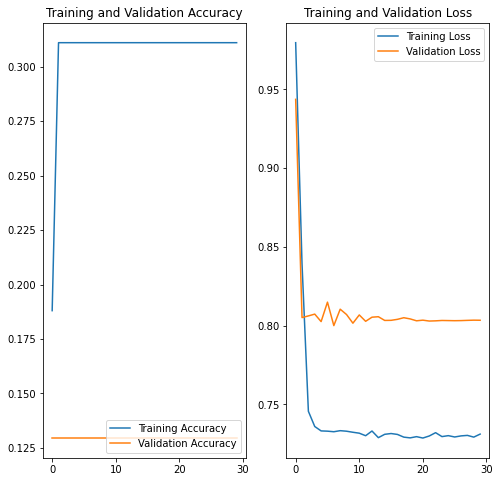

In [42]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()